In [ ]:
pip install openai tiktoken easyocr opencv-python-headless

In [ ]:
# Importaciones principales y configuración del cliente
import base64
from openai import OpenAI
from IPython.display import Image, display, Markdown # Para mostrar imágenes y texto formateado
from google.colab import userdata # Para acceder a los secretos
from PIL import Image
import math
import tiktoken
import cv2
import easyocr

client = OpenAI(
    api_key=userdata.get('OPENAI_API_KEY'),
)

# Modelo a usar GPT-4.1-mini
modelo = "gpt-4.1-mini"
print(f"Usando el modelo: {modelo}")
encoding = tiktoken.encoding_for_model("gpt-4o-mini")

def encode_image_to_base64_from_path(image_path):
    #Codifica una imagen a Base64.
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def analyze_image_with_gpt(prompt_text, local_image_path=None, max_tokens=5000, display_image_source=True):

    content_parts = [{"type": "text", "text": prompt_text}]


    base64_image = encode_image_to_base64_from_path(local_image_path)

    content_parts.append({
        "type": "image_url",
        "image_url": { "url": f"data:image/jpeg;base64,{base64_image}", "detail": "high" }
    })


    response = client.chat.completions.create(
        model=modelo,
        messages=[{ "role": "user", "content": content_parts }],
        max_tokens=max_tokens
    )

    return response.choices[0].message.content



In [ ]:
def calcular_gasto_imagen_openai(width: int, height: int) -> tuple[int, float]:
    """
    Calcula el número de tokens y el costo estimado de una imagen
    enviada a la API de OpenAI (GPT-4o Vision).

    Args:
        width (int): El ancho de la imagen en píxeles.
        height (int): La altura de la imagen en píxeles.

    Returns:
        tuple[int, float]: Una tupla que contiene (tokens_consumidos, costo_estimado).
    """

    # 1. Redimensionamiento de la imagen
    # La dimensión más larga no debe exceder 2048px.
    # La dimensión más corta debe tener al menos 768px.
    # El aspecto ratio se mantiene.

    # Paso 1: Asegurarse de que la dimensión más larga no exceda 2048px
    if max(width, height) > 2048:
        aspect_ratio = width / height
        if width > height:
            width = 2048
            height = int(2048 / aspect_ratio)
        else:
            height = 2048
            width = int(2048 * aspect_ratio)

    # Paso 2: Asegurarse de que la dimensión más corta tenga al menos 768px
    if min(width, height) < 768:
        aspect_ratio = width / height
        if width < height:  # Si el ancho es la dimensión más corta
            width = 768
            height = int(768 / aspect_ratio)
        else:  # Si la altura es la dimensión más corta
            height = 768
            width = int(768 * aspect_ratio)

    # 2. Cálculo de Mosaicos (Tiles)
    # Cada mosaico es de 512px x 512px.
    tiles_width = math.ceil(width / 512)
    tiles_height = math.ceil(height / 512)
    total_tiles = tiles_width * tiles_height

    # 3. Cálculo de Tokens
    # Total tokens = (tiles × 170) + 85 base tokens.
    tokens_consumidos = (total_tiles * 170) + 85

    # 4. Cálculo del Precio
    # Precio por 1M tokens ($2).
    price_per_million_tokens = 10.00
    costo_estimado = (tokens_consumidos / 1_000_000) * price_per_million_tokens
    return tokens_consumidos, costo_estimado



def calcular_gasto_texto(tokens_in, tokens_out):
  price_input = 0.40  #Por millon de tokens
  price_output = 1.60 #Por millon de tokens

  costo_input = (tokens_in / 1_000_000) * price_input
  costo_output = (tokens_out / 1_000_000) * price_output
  total = costo_input + costo_output
  return total


def aplicar_OCR(path):
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  lector = easyocr.Reader(['en', 'es'], gpu=False)
  resultados = lector.readtext(img)
  solo_texto = [item[1] for item in resultados]
  return solo_texto


def respuesta_texto(prompt):
  message = [
          {
              "role": "user",
              "content": (
                  prompt
              )
          }
      ]

  response = client.chat.completions.create(
    model=modelo,
    messages=message)

  return response.choices[0].message.content

def procesar_imagen(path, prompt):
  imagen = Image.open(path)

  # Obtener dimensiones
  ancho, alto = imagen.size

  tokens_image, costo_imagen = calcular_gasto_imagen_openai(ancho, alto)

  respuesta = analyze_image_with_gpt(
        prompt_text=prompt,
        local_image_path=path
    )

  tokens_input = len(encoding.encode(prompt))
  tokens_output = len(encoding.encode(respuesta))
  costo_texto = calcular_gasto_texto(tokens_input, tokens_output)
  costo_total = costo_texto + costo_imagen
  print(f"Respuesta: {respuesta}")
  print(" ")
  print(f"Costo imagen: {costo_imagen} dolares")
  print(f"Costo texto: {costo_texto} dolares")
  print(f"Costo total: {costo_total} dolares")

def procesar_texto(path, prompt):
  texto_ocr = aplicar_OCR(path)
  print(f"OCR: {texto_ocr}")

  prompt_completo = f"""{prompt}
  {texto_ocr}
  """

  respuesta = respuesta_texto(prompt_completo)
  print(f"Respuesta GPT: {respuesta}")
  tokens_input = len(encoding.encode(prompt_completo))
  tokens_output = len(encoding.encode(respuesta))
  costo_texto = calcular_gasto_texto(tokens_input, tokens_output)
  print(" ")
  print(f"Costo texto: {costo_texto} dolares")

# **1. Ejemplo recibo digital**

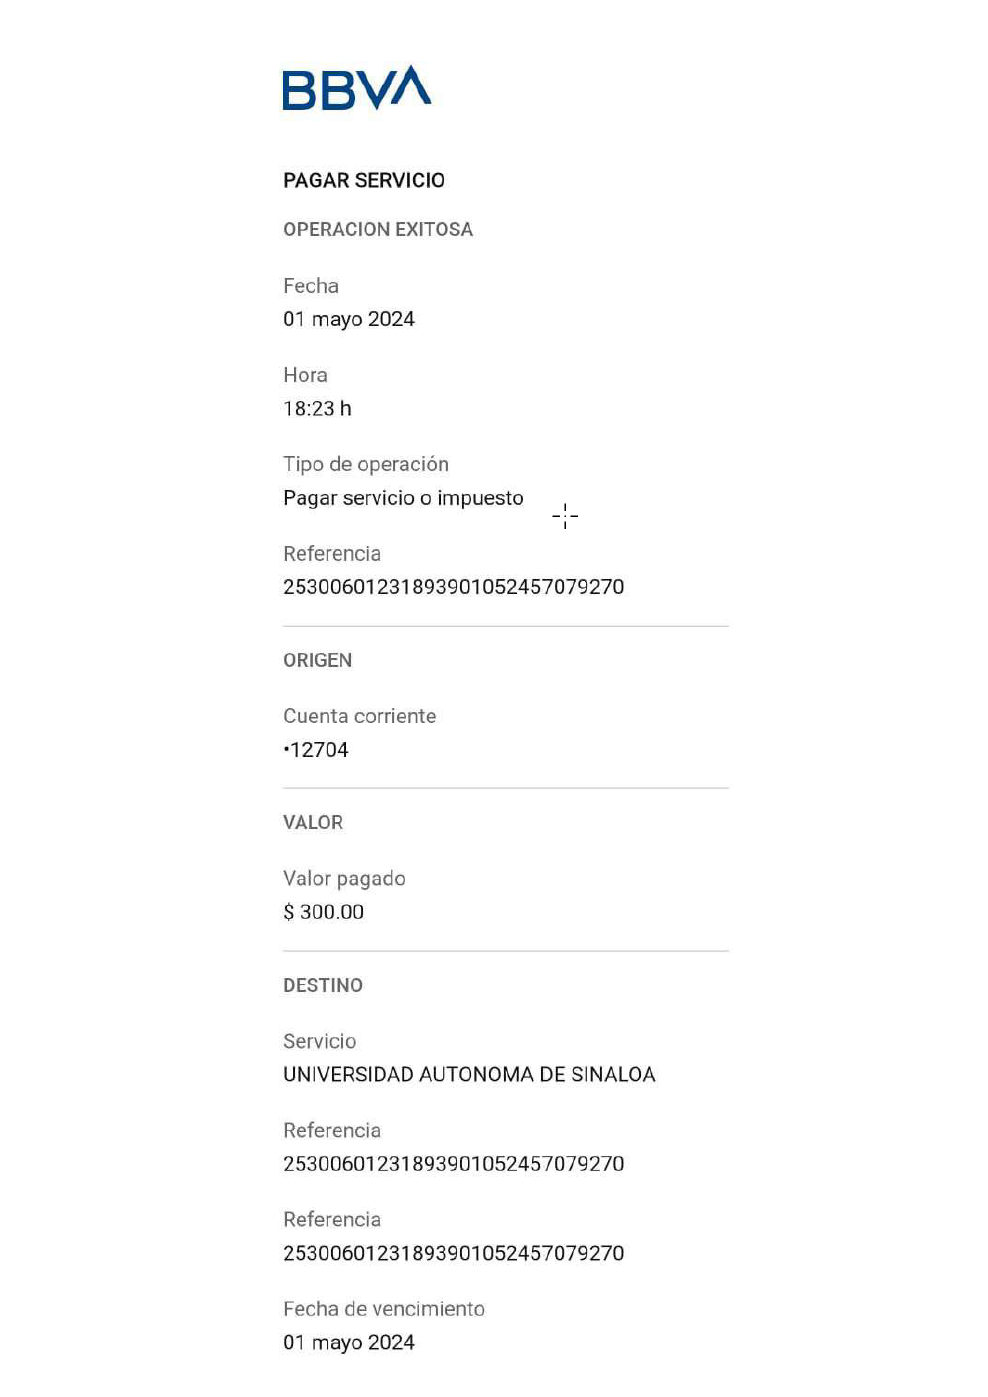

**GPT-4 Vision**

In [ ]:
path_1 = "/content/Documento.png"
prompt_1 = """Dame las siguientes caracteristicas del documento en formato Json:
- Banco
- Fecha
- Hora
- Tipo de operacion
- Referencia
- Valor pagado
- Servicio pagado
- Fecha de vencimiento
"""

procesar_imagen(path_1, prompt_1)

**OCR y GPT-4.1-mini**

In [ ]:
procesar_texto(path_1, prompt_1)

# **Ejemplo 2: Recibo escaneado**

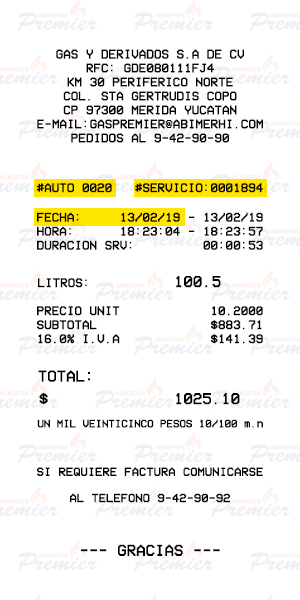

**GPT Vision:**

In [ ]:
path_2 = "/content/ReciboGas2.jpg"
prompt_2 = """Dame las siguientes caracteristicas  del documento en formato Json
- Empresa
- Fecha
- Hora
- Duracion del servicio
- Litros
- Precio unitario
- Precio total
"""

procesar_imagen(path_2, prompt_2)

**OCR y GPT:**

In [ ]:
procesar_texto(path_2, prompt_2)

# **Ejemplo 3: Caracteristicas de brasil**

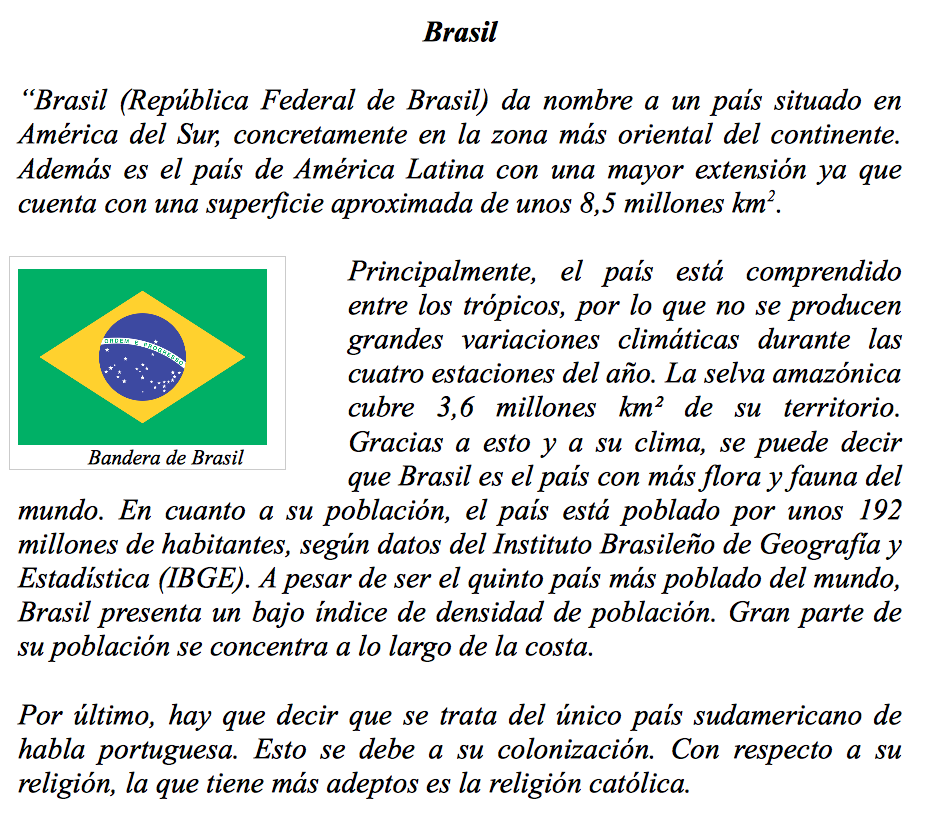

**GPT Vision:**

In [ ]:
path_3 = "/content/Brasil.png"
prompt_3 = """Dame las siguientes caracteristicas de brasil:
- Ubicacion
- Superficie
- Tamaño de su selva amazonica
- Poblacion
- Idioma

Dame la respuesta de forma estructurada en formato Json
"""

procesar_imagen(path_3, prompt_3)

**OCR y GPT:**

In [ ]:
prompt_3 = """Dame las siguientes caracteristicas de brasil:
- Ubicacion
- Superficie
- Tamaño de su selva amazonica
- Poblacion
- Idioma

Dame la respuesta de forma estructurada en formato Json
"""
procesar_texto(path_3, prompt_3)

# **Ejemplo 4: Resumen Texto**

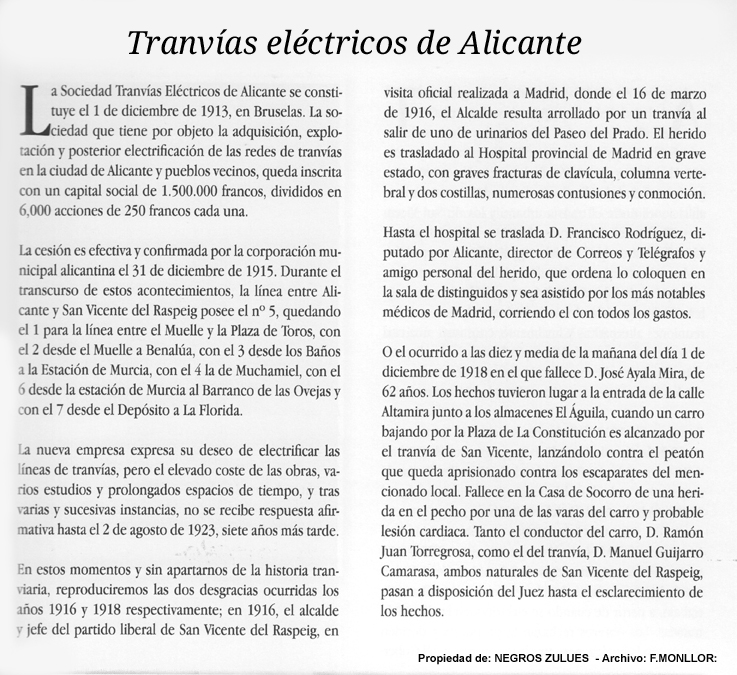

**GPT Vision**

In [ ]:
path_4 = "/content/Documento escaneado Tranvias.jpg"
prompt_4 = """Dame un resumen breve del documento con los puntos mas importantes
"""

procesar_imagen(path_4, prompt_4)

**OCR y GPT:**

In [ ]:
prompt_4 = """Dame un resumen breve con los puntos mas importantes del siguiente texto
"""

procesar_texto(path_4, prompt_4)

# **Ejemplo 5: Documento antiguo**

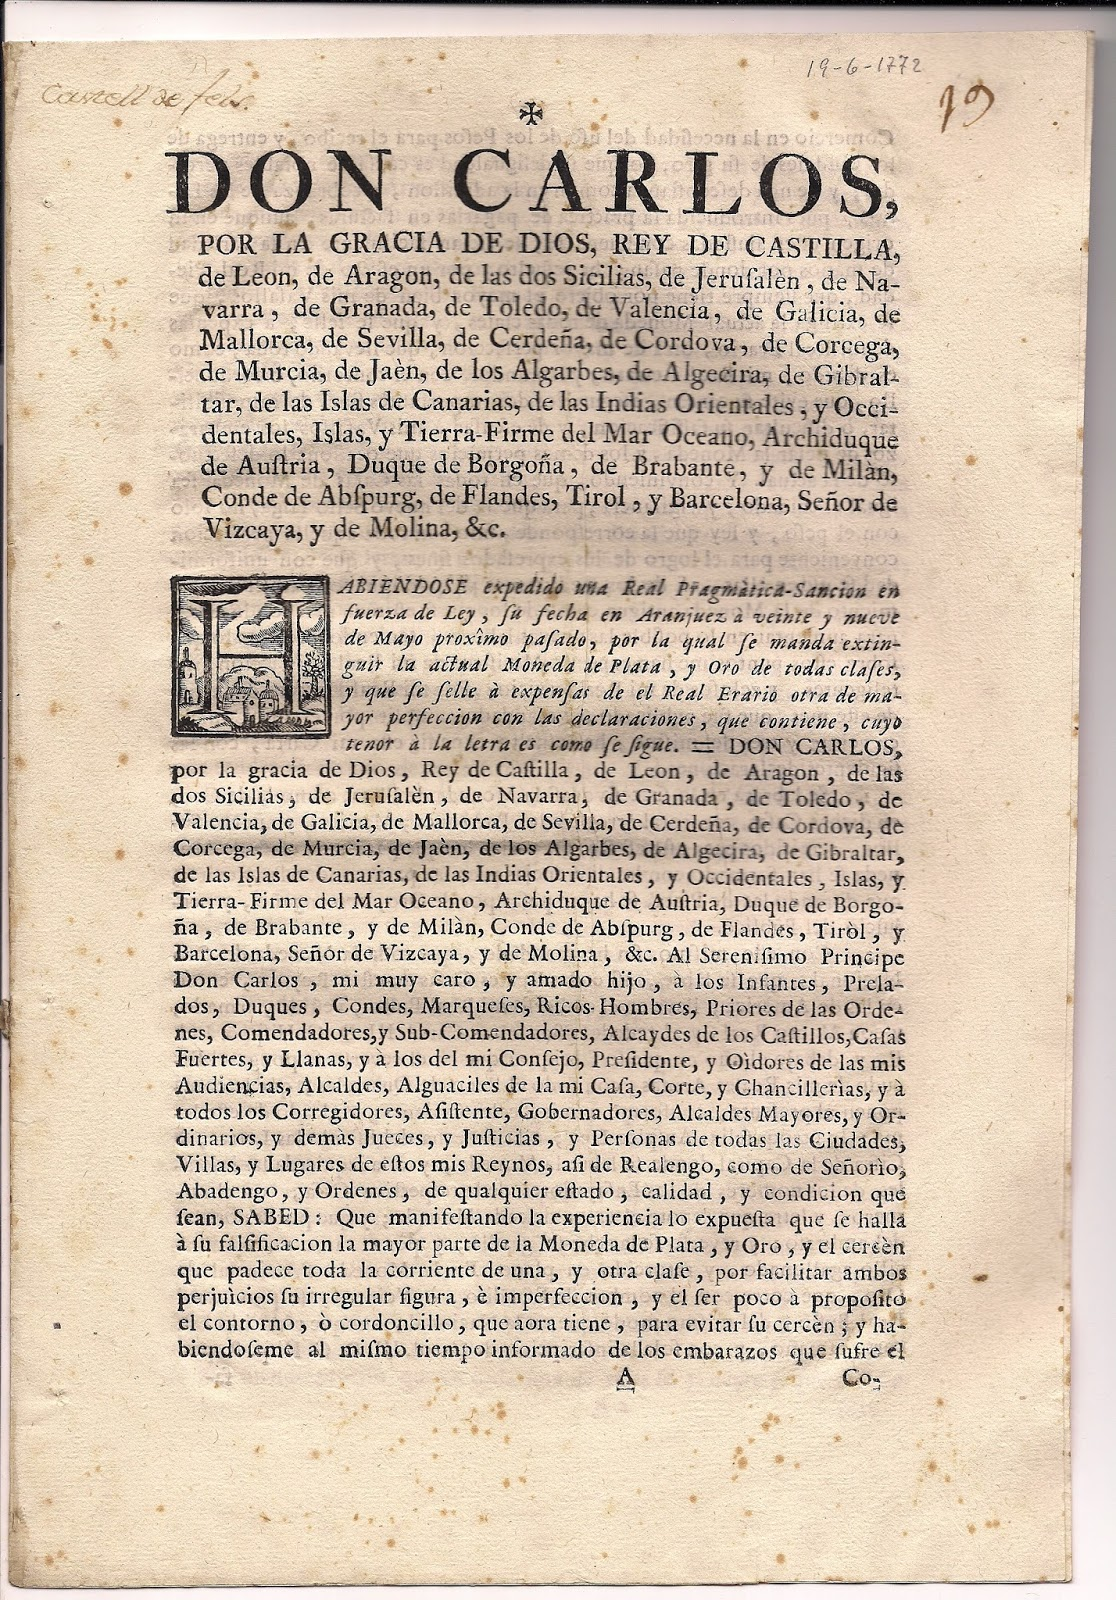

**GPT Vision**

In [ ]:
path_5 = "/content/carlos III 1.jpg"
prompt_5 = """Dame un resumen breve del documento con los puntos mas importantes
"""

procesar_imagen(path_5, prompt_5)

**OCR y GPT:**

In [ ]:
prompt_5 = """Dame un resumen breve con los puntos mas importantes del siguiente texto
"""

procesar_texto(path_5, prompt_5)

# **Ejercicio:**

Realiza un prompt para extraer los datos que se encuentran marcados en la siguiente imagen De la siguiente imagen:
*   Conmutador
*   Fecha
*   Fecha vencimiento
*   Nota de consumo
*   Cuenta
*   Lectura actual
*   Historico de consumos de cada mes

Haz una comparacion de los resultados y costos usando GPT-Vision y OCR + GPT



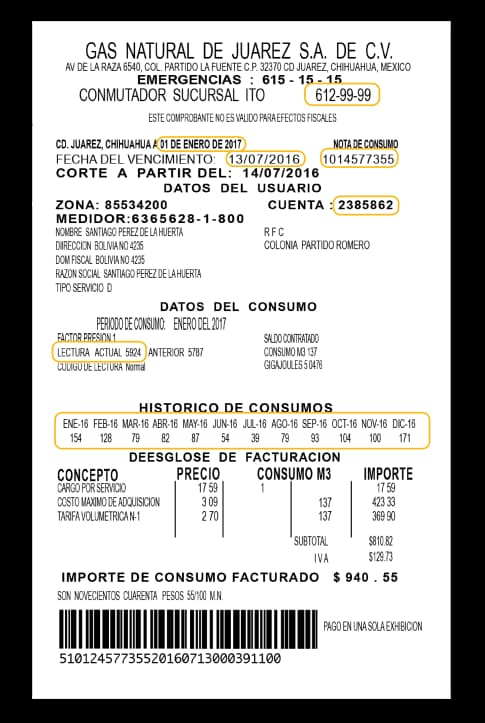

In [ ]:
path_ejercicio = "/content/ReciboGas.jpg"
prompt_ejercicio = """
"""

procesar_imagen(path_ejercicio, prompt_ejercicio)

In [ ]:
procesar_texto(path_ejercicio, prompt_ejercicio)